In [13]:
from collections import defaultdict
import csv
import math
import os.path
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
def mwu(expert_classification_list, correct_values_list, e=None):
    """
        expert_classification: List of classification list for each expert
        e_param: Param e in MWU formula  
        
        Returns: list of p for each expert 
    """
    loss = [0]
    m = len(expert_classification_list)  # number of experts
    T = len(expert_classification_list[0])  # total steps
    print(f"m = {m}")
    print(f"T = {T}")
    if e is None:  # use default
        e = math.sqrt(math.log(m) / T) 
    w = [1 for _ in range(m)]  # initial weights
    p = [1 / w[i] for i in range(m)]  # initial probabilities
    
    for t in range(T):
        # If wants to choose an expert to follow
        # expert_choosed = np.random.choice([i for i in range(T)], 1, p=p)[0]
        expert_losses = [1 if expert_classification_list[i][t] != correct_values_list[t] 
                         else 0 
                         for i in range(m)]
        current_loss = sum([expert_losses[i] * p[i] 
                            for i in range(m)])
        loss.append(loss[t] + current_loss)
        
        for i in range(m):
            w[i] = w[i] * math.e ** (-e * expert_losses[i])
        
        sum_weights = sum(w)
        for i in range(m):
            p[i] = w[i] / sum_weights
            
        yield (p, loss)        

In [3]:
# Open Mnist data
# https://pjreddie.com/projects/mnist-in-csv/
# Image shape = (28 x 28)
file_url = 'https://pjreddie.com/media/files/'

test_data = 'mnist_test.csv'
train_data = 'mnist_train.csv'

# download file if not exists:
for file_name in [test_data, train_data]:
    if not os.path.isfile(file_name):
        print(f"downloading {file_name}...")
        urllib.request.urlretrieve(file_url + file_name, file_name) 

train_X = []
train_Y = []
test_X = []
test_Y = []

# extract only zero and ones
allowed_numbers = [0, 1]

print("parsing files...")
with open(train_data) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        int_row = [int(value) for value in row]
        if int_row[0] in allowed_numbers:
            train_X.append(int_row[1:])
            train_Y.append(int_row[0])
            
with open(test_data) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        int_row = [int(value) for value in row]
        if int_row[0] in allowed_numbers:
            test_X.append(int_row[1:])
            test_Y.append(int_row[0])

print('finish')

parsing files...
finish


In [4]:
# define weak classifiers
# the classifier for the pixel_i is a classifier f(x) where 
# f(x) = digit_1 if x <= K and f(x) is digit_2 otherwise  
classifier_list = []
for i in range(28 * 28):
    count_first_class_times = defaultdict(int)
    count_second_class_times = defaultdict(int)
    for j in range(len(train_Y)):
        if train_Y[j] == allowed_numbers[0]:
            count_first_class_times[train_X[j][i]] += 1
        else:
            count_second_class_times[train_X[j][i]] += 1
    diffs = [count_second_class_times[k] - count_first_class_times[k] for k in range(255)]
    sum_diffs = []
    
    for j in range(255):
        if j == 0:
            sum_diffs.append(diffs[0])
        else:
            sum_diffs.append(diffs[j] + sum_diffs[j-1])
    
    max_deviation = max([abs(sum_diff) for sum_diff in sum_diffs])
    for pixel_level in range(255):
        if abs(sum_diffs[pixel_level]) == max_deviation:
            classifier_list.append((pixel_level,
                                    (False if sum_diffs[pixel_level] > 0
                                     else True)))
            break

In [5]:
# get the expert classification list
expert_classification_list = []

for classifier_index in range(len(classifier_list)):
    classifier_treshold, is_first_digit_flag = classifier_list[classifier_index]
    expert_classifications = []
    for train_x in train_X:
        if train_x[classifier_index] <= classifier_treshold:
            if is_first_digit_flag: 
                expert_classifications.append(allowed_numbers[0])
            else:
                expert_classifications.append(allowed_numbers[1])
        else:
            if is_first_digit_flag: 
                expert_classifications.append(allowed_numbers[1])
            else:
                expert_classifications.append(allowed_numbers[0])
    expert_classification_list.append(expert_classifications)

In [26]:
def classify_by_experts(p, digit_x):
    total_p_first_digit = 0
    total_p_second_digit = 0
    for classifier_index in range(len(classifier_list)):
        classifier_treshold, is_first_digit_flag = classifier_list[classifier_index]
        expert_classifications = []
        if digit_x[classifier_index] <= classifier_treshold:
            if is_first_digit_flag: 
                total_p_first_digit += p[classifier_index]
            else:
                total_p_second_digit += p[classifier_index]
        else:
            if is_first_digit_flag: 
                total_p_second_digit += p[classifier_index]
            else:
                total_p_first_digit += p[classifier_index]
    if total_p_first_digit >= total_p_second_digit:
        return allowed_numbers[0]
    return allowed_numbers[1] 

def get_error(p):
    errors = 0
    total = 0
    for i in range(len(test_X)):
        if classify_by_experts(p, test_X[i]) != test_Y[i]:
            errors += 1
        total += 1
    return errors / total

def get_error_train(p):
    errors = 0
    total = 0
    for i in range(len(train_X)):
        if classify_by_experts(p, train_X[i]) != train_Y[i]:
            errors += 1
        total += 1
    return errors / total

def get_error_from_expert(classifier_index, list_X, list_Y):
    errors = 0
    total = 0
    for i in range(len(list_X)):
        digit_x = list_X[i]
        classifier_treshold, is_first_digit_flag = classifier_list[classifier_index]
        if digit_x[classifier_index] <= classifier_treshold:
            if is_first_digit_flag: 
                classification = 0
            else:
                classification = 1
        else:
            if is_first_digit_flag: 
                classification = 1
            else:
                classification = 0
        if classification != list_Y[i]:
            errors += 1
        total += 1
    return errors / total

In [7]:
error_list = []
ps = []
step = 0
total_steps = len(train_Y)
for (p, loss) in mwu(expert_classification_list, train_Y):
    ps.append(p.copy())
    error = get_error(p)
    error_list.append(error)
    clear_output(wait=True)
    print(f"Step {step}/{total_steps}. Error = {error}")
    step += 1

Step 12664/12665. Error = 0.009456264775413711


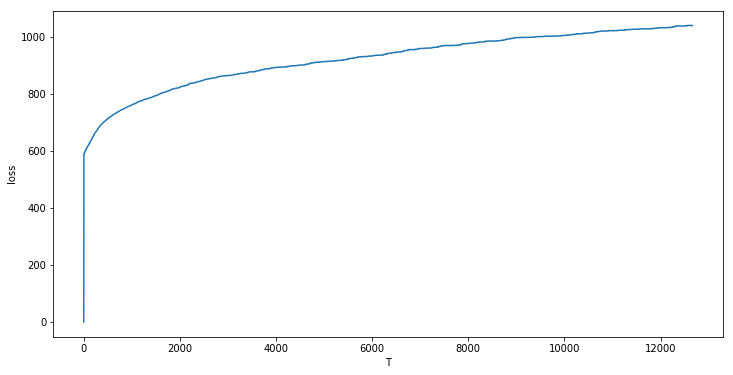

In [14]:
# print the loss through the time
plt.xlabel('T')
plt.ylabel('loss')
plt.plot(loss)

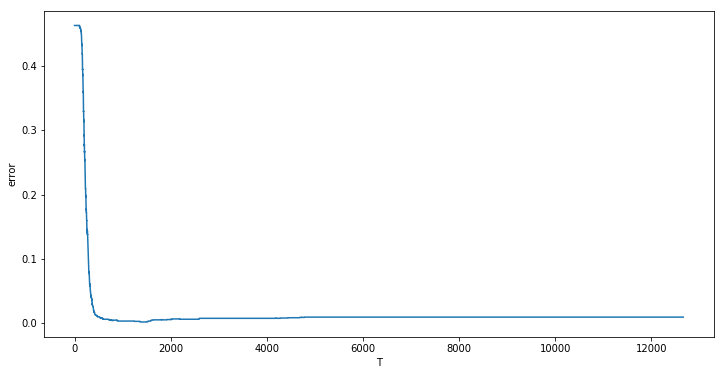

In [15]:
# print the loss through the time
plt.xlabel('T')
plt.ylabel('error')
plt.plot(error_list)

In [28]:
# find p with minimum error
min_error = min(error_list)
for i in range(len(error_list)):
    if error_list[i] == min_error:
        p = ps[i]
        steps_choosed = i
        print(f"Best index = {i}")
        break

p_matrix = np.reshape(np.array(p), (28 , 28))

Best index = 1364


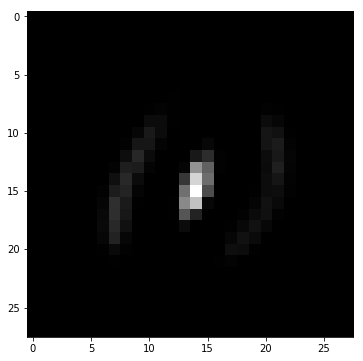

In [17]:
# plot most important pixels for classify
plt.imshow(p_matrix, cmap='gray')
plt.show()

Max Error = 0.482747729964469
Min Error = 0.013975523095144098


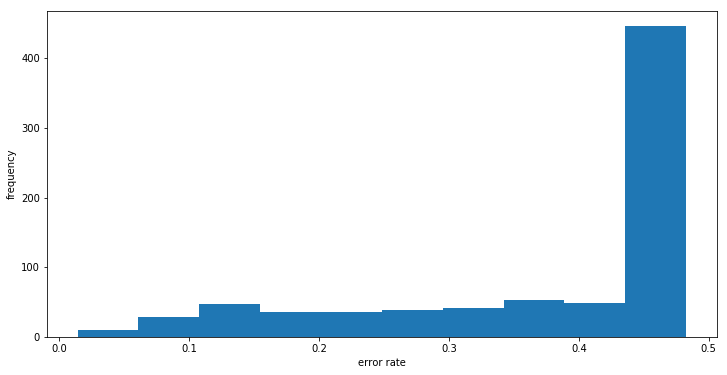

In [30]:
dist = []
for expert_index in range(len(classifier_list)):
    dist.append(get_error_from_expert(expert_index, train_X, train_Y))

plt.xlabel('error rate')
plt.ylabel('frequency')
plt.hist(dist)  
print(f"Max Error = {max(dist)}")
print(f"Min Error = {min(dist)}")

In [29]:
print(f"Choosed final p Error (Test) = {get_error(p)}")
print(f"Choosed final p Error (Train) = {get_error_train(p)}")
print(f"Number steps total {steps_choosed}. Number steps escolhido {len(train_X)}")

Choosed final p Error (Test) = 0.0018912529550827422
Choosed final p Error (Train) = 0.008211606790367153
Number steps total 1364. Number steps escolhido 12665
